In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import random
from random import shuffle
from skimage.transform import rotate
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy
import scipy.io as sio
from scipy.io import loadmat

In [2]:
data = sio.loadmat('Indian_pines.mat')['indian_pines']
rotulos = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

In [3]:
print(f'Dimensão dos dados: {data.shape}')
print(f'Dimensão dos rótulos: {rotulos.shape}')
print(f'Classes: {np.unique(rotulos)}')

Dimensão dos dados: (145, 145, 220)
Dimensão dos rótulos: (145, 145)
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


# Exploração dos dados

## Distribuição de classes

In [4]:
sumario = pd.DataFrame([{'Rotulo': label, 'Quantidade': np.sum(rotulos == val)} for val, label in enumerate(np.unique(rotulos))])
sumario

,Rotulo,Quantidade
0,0,10776
1,1,46
2,2,1428
3,3,830
4,4,237
5,5,483
6,6,730
7,7,28
8,8,478
9,9,20


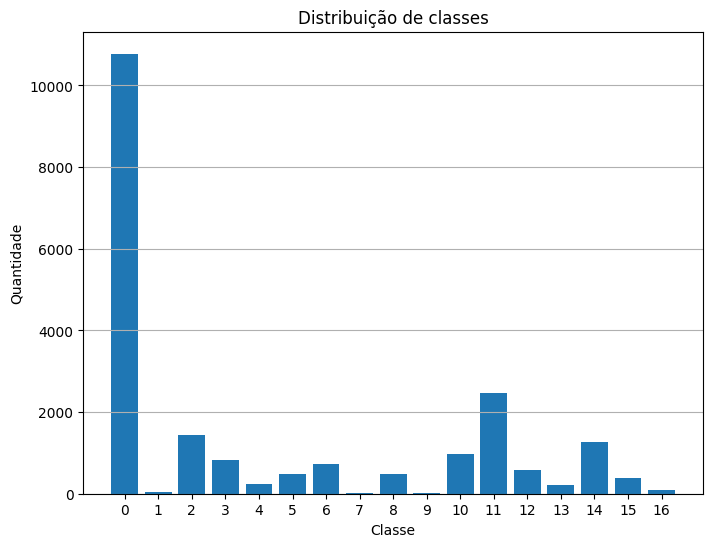

In [5]:
unique_classes, class_counts = np.unique(rotulos, return_counts=True)

# Plot class distribution
plt.figure(figsize=(8, 6))
plt.bar(unique_classes, class_counts)
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.title(f'Distribuição de classes')
plt.xticks(unique_classes)
plt.grid(axis='y')
plt.show()

## Visualizando bandas selecionadas

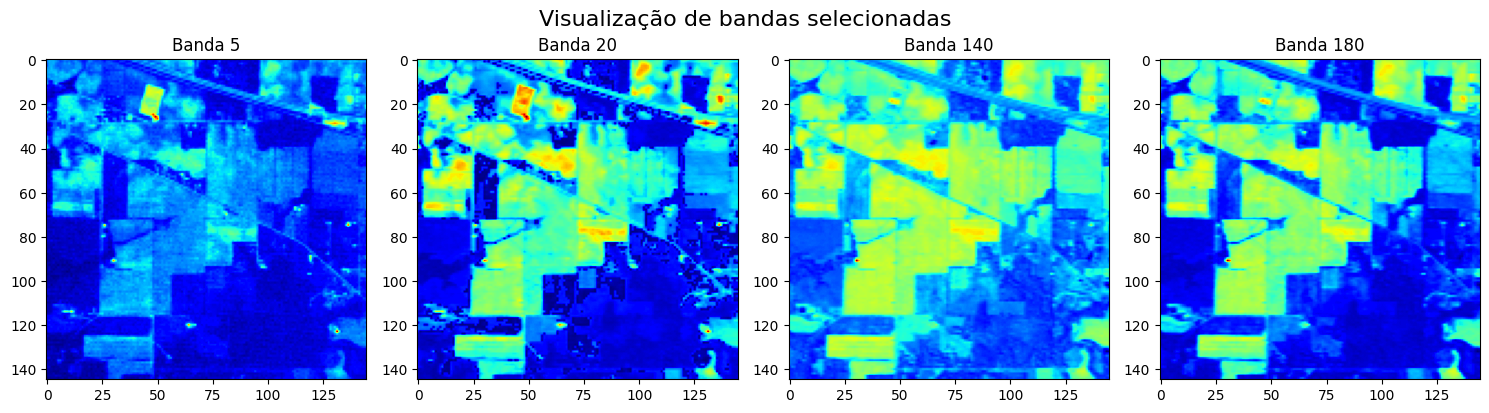

In [6]:
bandas_selecionadas = [5, 20, 140, 180]

num_bandas_selecionadas = len(bandas_selecionadas)
num_plots = num_bandas_selecionadas // 4 + (1 if num_bandas_selecionadas % 4 != 0 else 0)
fig, axes = plt.subplots(num_plots, 4, figsize=(15, num_plots * 4))
fig.suptitle(f'Visualização de bandas selecionadas', fontsize=16)
if num_plots == 1:
    axes = [axes]
for i, band_indice in enumerate(bandas_selecionadas):
    row_idx = i // 4
    col_idx = i % 4
    axes[row_idx][col_idx].imshow(data[:,:,band_indice], cmap='jet')
    axes[row_idx][col_idx].set_title(f'Banda {band_indice}')
plt.tight_layout()
plt.show()

## Assinatura espectral média das classes

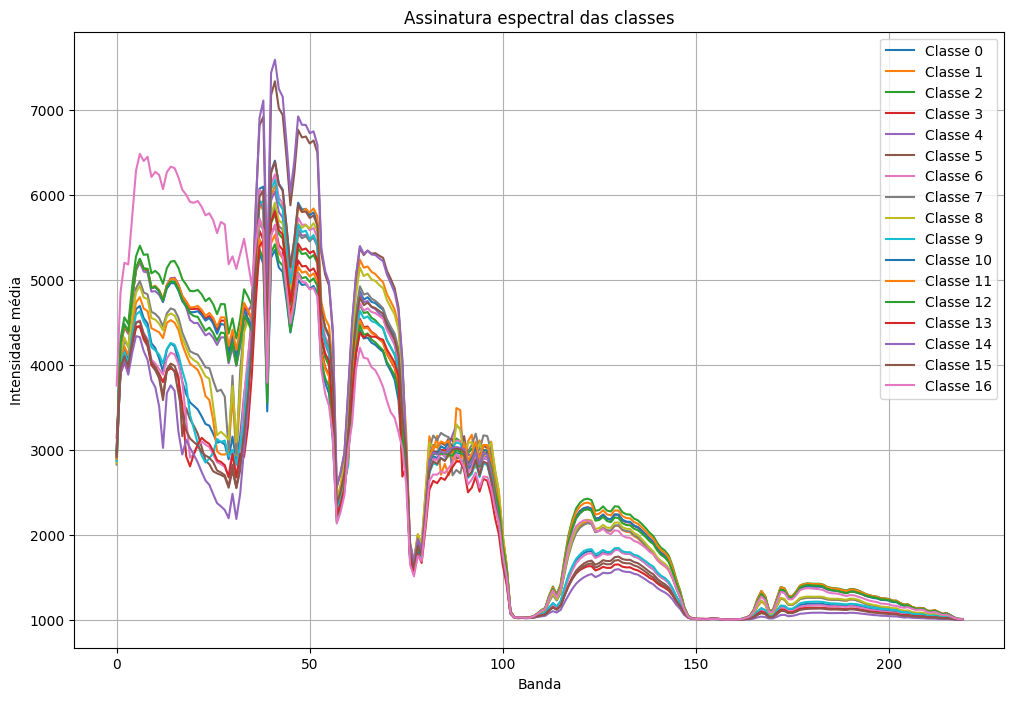

In [7]:
classes_unicas = np.unique(rotulos)
plt.figure(figsize=(12, 8))
for cls in classes_unicas:
    cls_indices = np.where(rotulos == cls)
    cls_samples = data[cls_indices]
    avg_spectrum = np.mean(cls_samples, axis=0)
    plt.plot(avg_spectrum, label=f'Classe {cls}')

plt.xlabel('Banda')
plt.ylabel('Intensidade média')
plt.title(f'Assinatura espectral das classes')
plt.legend()
plt.grid(True)
plt.show()

## Imagem dos rótulos

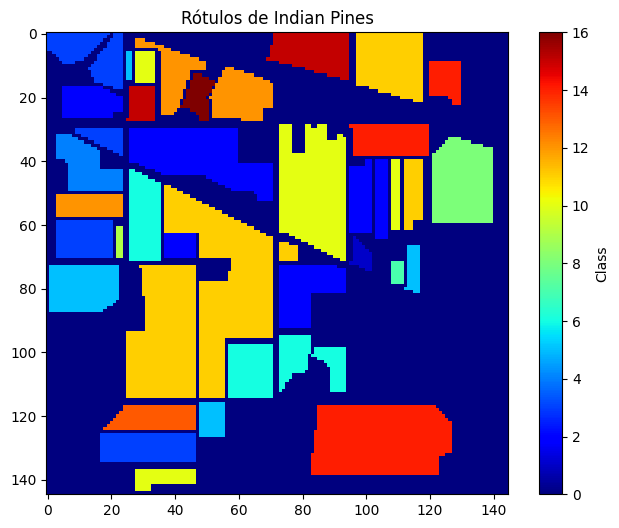

In [8]:
plt.figure(figsize=(8, 6))
plt.imshow(rotulos, cmap='jet')
plt.title(f'Rótulos de Indian Pines')
plt.colorbar(label='Class')
plt.show()

# Pré-processamento

## Normalização

In [9]:
max_valor = np.max(data)
min_valor = np.min(data)
data_normalizada = (data - min_valor) / (max_valor - min_valor)

### Visualizando a mudança após a normalização

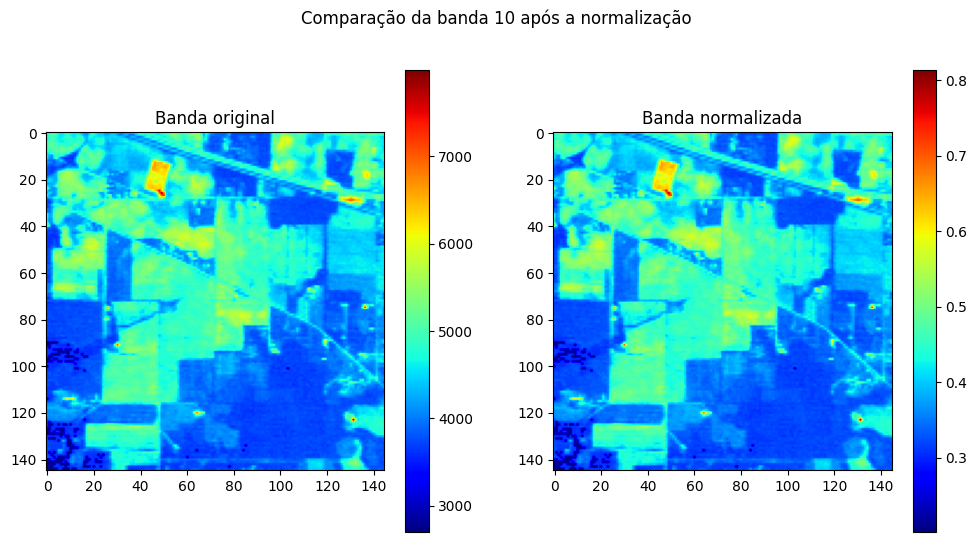

In [10]:
banda_original = data[:, :, 10]
banda_normalizada = data_normalizada[:, :, 10]

plt.figure(figsize=(12, 6))

# Original data
plt.subplot(1, 2, 1)
plt.imshow(banda_original, cmap='jet')
plt.title('Banda original')
plt.colorbar()

# Normalized data
plt.subplot(1, 2, 2)
plt.imshow(banda_normalizada, cmap='jet')
plt.title('Banda normalizada')
plt.colorbar()

plt.suptitle(f'Comparação da banda 10 após a normalização')
plt.show()

## Redução de dimensionalidade

### Análise da explicação dos componentes principais do PCA

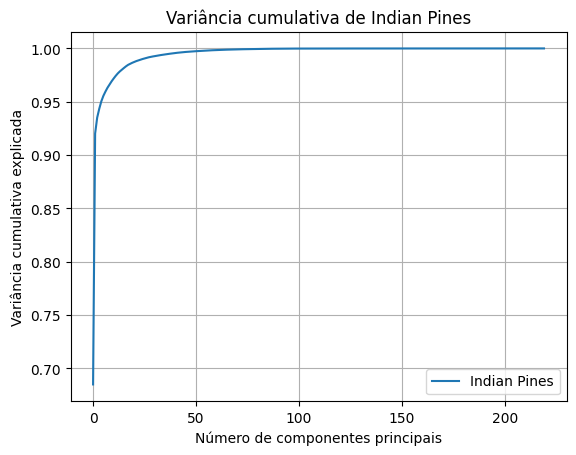

In [11]:
from sklearn.decomposition import PCA

data_achatada = data_normalizada.reshape(-1, data_normalizada.shape[-1])

pca = PCA()
pcX = pca.fit_transform(data_achatada)
ev = pca.explained_variance_ratio_
cumulative_var = np.cumsum(ev)

plt.plot(cumulative_var, label='Indian Pines')

plt.xlabel('Número de componentes principais')
plt.ylabel('Variância cumulativa explicada')
plt.title('Variância cumulativa de Indian Pines')
plt.legend()
plt.grid(True)
plt.show()

### PCA

In [12]:
# Transformando os dados para ficar um array 2D
data_2d = data.reshape(data.shape[0] * data.shape[1], data.shape[2])

# Aplicando PCA
pca = PCA(n_components=22)
data_pos_pca = pca.fit_transform(data_2d)

# Deixando o rotulos com 1 dimensão
rotulos_1d = rotulos.reshape(rotulos.shape[0] * rotulos.shape[1])

## Limpeza de valores nulos para treinamento posterior

In [13]:
def limpar_pixels_vazios(X, y):
    mask = y != 0

    X = X[mask]
    y = y[mask]

    return X, y

data_pos_filtro, rotulos_pos_filtro = limpar_pixels_vazios(data_pos_pca, rotulos_1d)

## Divisão entre treino e teste

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_pos_filtro, rotulos_pos_filtro, test_size=0.2, random_state=42)

## Oversampling

In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
data_balanced, rotulos_balanced = smote.fit_resample(X_train, y_train)

In [16]:
sumario_balanced = pd.DataFrame([{'Rotulo': label, 'Quantidade': np.sum(rotulos_balanced == val)} for val, label in enumerate(np.unique(rotulos_balanced))])
sumario_balanced

,Rotulo,Quantidade
0,1,0
1,2,1986
2,3,1986
3,4,1986
4,5,1986
5,6,1986
6,7,1986
7,8,1986
8,9,1986
9,10,1986


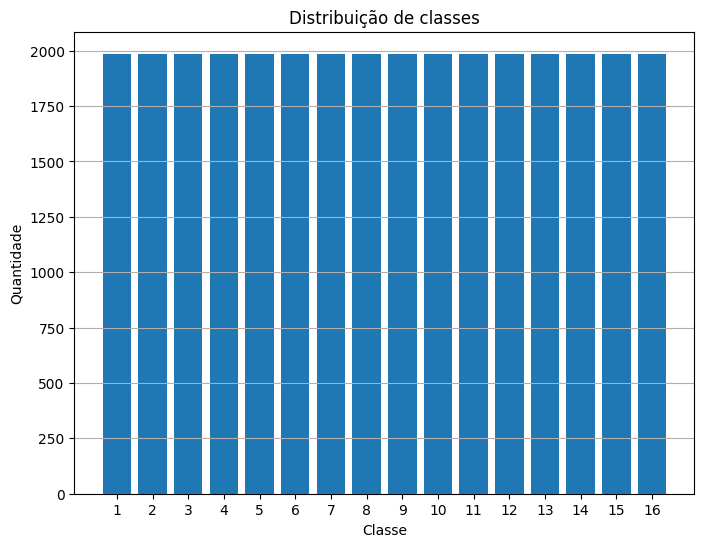

In [17]:
unique_classes_balanced, class_counts_balanced = np.unique(rotulos_balanced, return_counts=True)

# Plot class distribution
plt.figure(figsize=(8, 6))
plt.bar(unique_classes_balanced, class_counts_balanced)
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.title(f'Distribuição de classes')
plt.xticks(unique_classes_balanced)
plt.grid(axis='y')
plt.show()

# Classificação

## Modelo XGboost

In [18]:
from xgboost import XGBClassifier

xgbmodel = XGBClassifier(
    n_estimators=500, max_depth=15,
    learning_rate=0.01,
    objective='multi:softmax',
    num_class=16
)

xgbmodel.fit(data_balanced, rotulos_balanced - 1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=16,
              num_parallel_tree=None, ...)

In [19]:
xgb_pred = xgbmodel.predict(X_test)

# Métricas para comparação de modelos

In [20]:
from sklearn.metrics import classification_report

print(classification_report(xgb_pred + 1, y_test))

              precision    recall  f1-score   support

           1       0.75      0.92      0.83        13
           2       0.76      0.77      0.77       266
           3       0.75      0.80      0.77       164
           4       0.72      0.61      0.66        46
           5       0.93      0.94      0.93        96
           6       0.92      0.92      0.92       156
           7       1.00      0.67      0.80         6
           8       0.98      0.97      0.98       106
           9       1.00      1.00      1.00         2
          10       0.82      0.80      0.81       213
          11       0.83      0.85      0.84       462
          12       0.82      0.75      0.78       134
          13       0.94      0.94      0.94        34
          14       0.92      0.93      0.93       238
          15       0.69      0.68      0.69        98
          16       0.94      0.94      0.94        16

    accuracy                           0.84      2050
   macro avg       0.86   